In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import style 
style.use('ggplot')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['font.sans-serif'] = ['Simhei'] 

import re
import jieba.posseg as psg
import itertools
#conda install -c anaconda gensim
from gensim import corpora,models 

# pip install wordcloud
from wordcloud import WordCloud,ImageColorGenerator
from collections import Counter

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import graphviz

In [2]:
raw_data=pd.read_csv('./low.csv')
raw_data.head()


,机型,IMEI,日期,类别,描述
0,T2x,4b663739e8d3aeefa41649f1b428ed08,2022-06-24,发热赛道,用户在天猫vivo官方旗舰店购机T2x，反馈充电的时候充电器冒烟，手机发热严重，造成家里的电...
1,T2x,7ca7d62223098ffef00d091adebb6b03,2022-07-07,内置程序,机器出现指纹解锁不灵敏，点击电池图标外部显示不在外部显现的问题，现要求换机处理。所在位置：广...
2,T2x,aeb9db84819223a52b9f91feeebfd26d,2022-07-10,性能赛道,来访用户名：宋亚轩.用户地址：河北省石家庄市栾城区窦妪镇反馈内容：用户来访在线客服7527反...
3,T2x,9c7933532d81adab67981abae8abdc35,2022-07-11,性能赛道,机器反应慢，扫码无反应。6月29日送修至北京市朝阳区合生汇售后，故障未重现，建议其观察使用。...
4,T2x,a224b56d53b761b092950fd59480a1d8,2022-07-14,内置程序,用户问题：在专卖店买的手机给其拿了样品机，使用三天手机锁屏了不能打开，前往门店，表示自己不记...


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52455 entries, 0 to 52454
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   机型      52455 non-null  object
 1   IMEI    52455 non-null  object
 2   日期      52455 non-null  object
 3   类别      52455 non-null  object
 4   描述      52442 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [4]:
raw_data.columns

Index(['机型', 'IMEI', '日期', '类别', '描述'], dtype='object')

In [5]:
reviews=raw_data[['类别','描述']]
print('去重之前：',reviews.shape[0])
reviews=reviews.drop_duplicates()
print('去重之后：',reviews.shape[0])

去重之前： 52455
去重之后： 50107


In [6]:
reviews.head()

,类别,描述
0,发热赛道,用户在天猫vivo官方旗舰店购机T2x，反馈充电的时候充电器冒烟，手机发热严重，造成家里的电...
1,内置程序,机器出现指纹解锁不灵敏，点击电池图标外部显示不在外部显现的问题，现要求换机处理。所在位置：广...
2,性能赛道,来访用户名：宋亚轩.用户地址：河北省石家庄市栾城区窦妪镇反馈内容：用户来访在线客服7527反...
3,性能赛道,机器反应慢，扫码无反应。6月29日送修至北京市朝阳区合生汇售后，故障未重现，建议其观察使用。...
4,内置程序,用户问题：在专卖店买的手机给其拿了样品机，使用三天手机锁屏了不能打开，前往门店，表示自己不记...


In [7]:
# 数据清洗
info = re.compile('([0-9a-zA-Z]|_x0000_|手机|华为|机器|用户|服务)')
reviews['描述'] = reviews['描述'].apply(lambda x: info.sub('', str(x)))
reviews['类别'] = reviews['类别'].apply(lambda x: info.sub('', str(x)))

In [8]:
reviews.head()

,类别,描述
0,发热赛道,在天猫官方旗舰店购机，反馈充电的时候充电器冒烟，发热严重，造成家里的电线出现损坏，麻烦核实处...
1,内置程序,出现指纹解锁不灵敏，点击电池图标外部显示不在外部显现的问题，现要求换机处理。所在位置：广东东...
2,性能赛道,来访名：宋亚轩.地址：河北省石家庄市栾城区窦妪镇反馈内容：来访在线客服反应才买了十多天没有安...
3,性能赛道,反应慢，扫码无反应。月日送修至北京市朝阳区合生汇售后，故障未重现，建议其观察使用。其取机后发...
4,内置程序,问题：在专卖店买的给其拿了样品机，使用三天锁屏了不能打开，前往门店，表示自己不记得设置过密码...


In [9]:
#分词，由元组组成的list
content=reviews['描述']
seg_content=content.apply( lambda s:  [(x.word,x.flag) for x in psg.cut(s)] )  

seg_content.shape
len(seg_content)
print(seg_content[5])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\FOREST\AppData\Local\Temp\jieba.cache
Loading model cost 0.658 seconds.
Prefix dict has been built successfully.


(50107,)

50107

[('出现', 'v'), ('卡顿', 'nrt'), ('黑屏', 'nr'), ('且', 'zg'), ('半天', 'm'), ('缓不', 'd'), ('过来', 't'), ('的', 'uj'), ('现象', 'n'), ('，', 'x'), ('其', 'r'), ('之前', 'f'), ('来电', 'v'), ('反馈', 'v'), ('为', 'p'), ('其', 'r'), ('建', 'v'), ('品质', 'n'), ('单', 'n'), ('分析', 'vn'), ('，', 'x'), ('其', 'r'), ('表示', 'v'), ('已经', 'd'), ('这么', 'r'), ('多天', 'm'), ('过去', 't'), ('了', 'ul'), ('也', 'd'), ('没', 'v'), ('结果', 'n'), ('，', 'x'), ('其', 'r'), ('表示', 'v'), ('其', 'r'), ('当前', 't'), ('的', 'uj'), ('天', 'n'), ('换机', 'nz'), ('时效', 'n'), ('快', 'a'), ('过', 'ug'), ('了', 'ul'), ('，', 'x'), ('表示', 'v'), ('你们', 'r'), ('这边', 'r'), ('的', 'uj'), ('人', 'n'), ('也', 'd'), ('不', 'd'), ('着急', 'a'), ('，', 'x'), ('要求', 'v'), ('尽快', 'd'), ('给出', 'v'), ('合理', 'vn'), ('处理', 'v'), ('方案', 'n'), ('。', 'x'), ('其', 'r'), ('当前', 't'), ('在', 'p'), ('湖北', 'ns'), ('，', 'x'), ('其', 'r'), ('表示', 'v'), ('之后', 'f'), ('将', 'd'), ('回', 'v'), ('河北', 'ns'), ('衡水市', 'ns'), ('区里', 's'), ('。', 'x'), ('单', 'n'), ('：', 'x'), ('-', 'x')]


In [10]:
#统计评论词数
n_word=seg_content.apply(lambda s: len(s))

len(n_word)
n_word.head(6)

50107

0     33
1     29
2    114
3     61
4    137
5     77
Name: 描述, dtype: int64

In [11]:
#得到各分词在第几条评论
n_content=[ [x+1]*y for x,y in zip(list(seg_content.index),list(n_word))] 
index_content_long=sum(n_content,[]) 
len(index_content_long)

1440528

In [12]:
sum([[2,2],[3,3,3]],[])
#分词及词性，拉平
seg_content.head()

seg_content_long=sum(seg_content,[])

seg_content_long

type(seg_content_long)
len(seg_content_long)

[2, 2, 3, 3, 3]

0    [(在, p), (天猫, n), (官方, n), (旗舰店, v), (购机, n), ...
1    [(出现, v), (指纹, n), (解锁, v), (不灵敏, l), (，, x), ...
2    [(来访, v), (名, q), (：, x), (宋亚轩, nr), (., m), (...
3    [(反应, vn), (慢, a), (，, x), (扫码, n), (无, v), (反...
4    [(问题, n), (：, x), (在, p), (专卖店, n), (买, v), (的...
Name: 描述, dtype: object

[('在', 'p'),
 ('天猫', 'n'),
 ('官方', 'n'),
 ('旗舰店', 'v'),
 ('购机', 'n'),
 ('，', 'x'),
 ('反馈', 'v'),
 ('充电', 'v'),
 ('的', 'uj'),
 ('时候', 'n'),
 ('充电器', 'n'),
 ('冒烟', 'v'),
 ('，', 'x'),
 ('发热', 'v'),
 ('严重', 'a'),
 ('，', 'x'),
 ('造成', 'v'),
 ('家里', 's'),
 ('的', 'uj'),
 ('电线', 'n'),
 ('出现', 'v'),
 ('损坏', 'v'),
 ('，', 'x'),
 ('麻烦', 'an'),
 ('核实', 'n'),
 ('处理', 'v'),
 ('地址', 'n'),
 ('：', 'x'),
 ('甘肃省', 'ns'),
 ('武威市', 'ns'),
 ('凉州区', 'ns'),
 ('新华', 'nz'),
 ('镇', 'n'),
 ('出现', 'v'),
 ('指纹', 'n'),
 ('解锁', 'v'),
 ('不灵敏', 'l'),
 ('，', 'x'),
 ('点击', 'v'),
 ('电池', 'n'),
 ('图标', 'n'),
 ('外部', 'f'),
 ('显示', 'v'),
 ('不', 'd'),
 ('在', 'p'),
 ('外部', 'f'),
 ('显现', 'v'),
 ('的', 'uj'),
 ('问题', 'n'),
 ('，', 'x'),
 ('现', 'tg'),
 ('要求', 'v'),
 ('换机', 'nz'),
 ('处理', 'v'),
 ('。', 'x'),
 ('所在位置', 'n'),
 ('：', 'x'),
 ('广东', 'ns'),
 ('东莞', 'ns'),
 ('寮', 'g'),
 ('步', 'q'),
 ('镇', 'n'),
 ('来访', 'v'),
 ('名', 'q'),
 ('：', 'x'),
 ('宋亚轩', 'nr'),
 ('.', 'm'),
 ('地址', 'n'),
 ('：', 'x'),
 ('河北省', 'ns'),
 ('石家庄市', 'ns'),
 ('

list

1440528

In [13]:
seg_content_long[0]

('在', 'p')

In [14]:
#得到加长版的分词、词性
word_long=[x[0] for x in seg_content_long]
nature_long=[x[1] for x in seg_content_long]

len(word_long)
len(nature_long)

1440528

1440528

In [15]:
#content_type拉长
n_content_type=[ [x]*y for x,y in zip(list(reviews['类别']),list(n_word))]
content_type_long=sum(n_content_type,[])

len(content_type_long)

1440528

In [16]:
review_long=pd.DataFrame({'index_content':index_content_long,
                        'word':word_long,
                        'nature':nature_long,
                        'content_type':content_type_long})
review_long.shape
review_long.head()

(1440528, 4)

,index_content,word,nature,content_type
0,1,在,p,发热赛道
1,1,天猫,n,发热赛道
2,1,官方,n,发热赛道
3,1,旗舰店,v,发热赛道
4,1,购机,n,发热赛道


In [17]:
review_long['nature'].unique()

array(['p', 'n', 'v', 'x', 'uj', 'a', 's', 'an', 'ns', 'nz', 'l', 'f',
       'd', 'tg', 'g', 'q', 'nr', 'm', 'b', 'vn', 'ul', 'r', 'c', 'nrt',
       't', 'ng', 'z', 'ug', 'ad', 'zg', 'ud', 'j', 'y', 'u', 'df', 'nt',
       'i', 'uz', 'vd', 'k', 'mq', 'vg', 'e', 'o', 'uv', 'ag', 'vq',
       'nrfg', 'h', 'yg', 'rz', 'rr', 'dg', 'mg'], dtype=object)

In [18]:
#去除标点符号
review_long_clean=review_long[review_long['nature']!='x']
review_long_clean.shape

(1114701, 4)

In [19]:
#导入停用词
stop_path=open('./stoplist.txt','r',encoding='UTF-8')
stop_words=stop_path.readlines()

len(stop_words)
stop_words[0:5]

5748

['\ufeff \n', '说\n', '人\n', '元\n', 'hellip\n']

In [20]:
#停用词
stop_words=[word.strip('\n') for word in stop_words]
stop_words[0:5]

['\ufeff ', '说', '人', '元', 'hellip']

In [21]:
#得到不含停用词的分词表
word_long_clean=list(set(word_long)-set(stop_words))
len(word_long_clean)

review_long_clean=review_long_clean[review_long_clean['word'].isin(word_long_clean)]
review_long_clean.shape

34115

(552229, 4)

In [22]:
#再次统计每条评论的分词数量
n_word=review_long_clean.groupby('index_content').count()['word']
n_word

index_word=[ list(np.arange(1,x+1)) for x in list(n_word)] 
index_word_long=sum(index_word,[]) 

len(index_word_long)

index_content
1        20
2        18
3        59
4        32
5        61
         ..
52450    70
52451    35
52453     3
52454    19
52455    29
Name: word, Length: 49931, dtype: int64

552229

In [23]:
review_long_clean['index_word']=index_word_long
review_long_clean.head()

,index_content,word,nature,content_type,index_word
1,1,天猫,n,发热赛道,1
2,1,官方,n,发热赛道,2
3,1,旗舰店,v,发热赛道,3
4,1,购机,n,发热赛道,4
6,1,反馈,v,发热赛道,5


In [24]:
review_long_clean.to_csv('./1_review_long_clean.csv')

In [25]:
n_review_long_clean=review_long_clean[[ 'n' in nat for nat in review_long_clean.nature]]
n_review_long_clean.shape
n_review_long_clean.head()

(254467, 5)

,index_content,word,nature,content_type,index_word
1,1,天猫,n,发热赛道,1
2,1,官方,n,发热赛道,2
4,1,购机,n,发热赛道,4
10,1,充电器,n,发热赛道,7
19,1,电线,n,发热赛道,11


In [26]:
n_review_long_clean.nature.value_counts()
n_review_long_clean.to_csv('./1_n_review_long_clean.csv')

n       197698
vn       19429
nr       15660
ns        8794
nz        5268
ng        3706
nrt       2574
an         907
nt         359
nrfg        72
Name: nature, dtype: int64

<Figure size 2000x1000 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

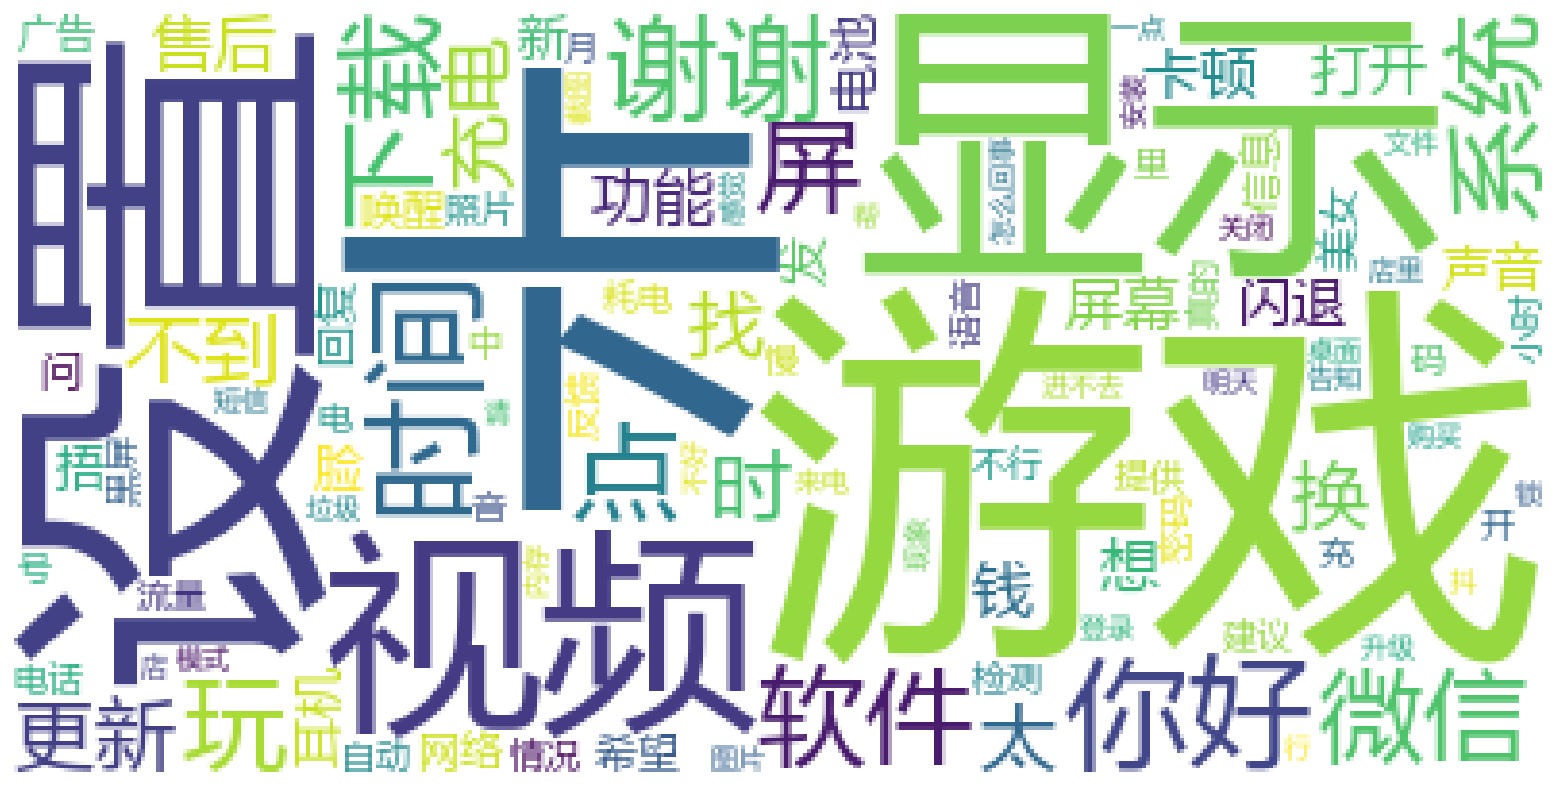

In [27]:
font=r"C:\Windows\Fonts\msyh.ttc"

wordcloud = WordCloud(font_path=font, max_words = 100, background_color='white') #width=1600,height=1200, mode='RGBA'
wordcloud.generate_from_frequencies(Counter(review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 2000x1000 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

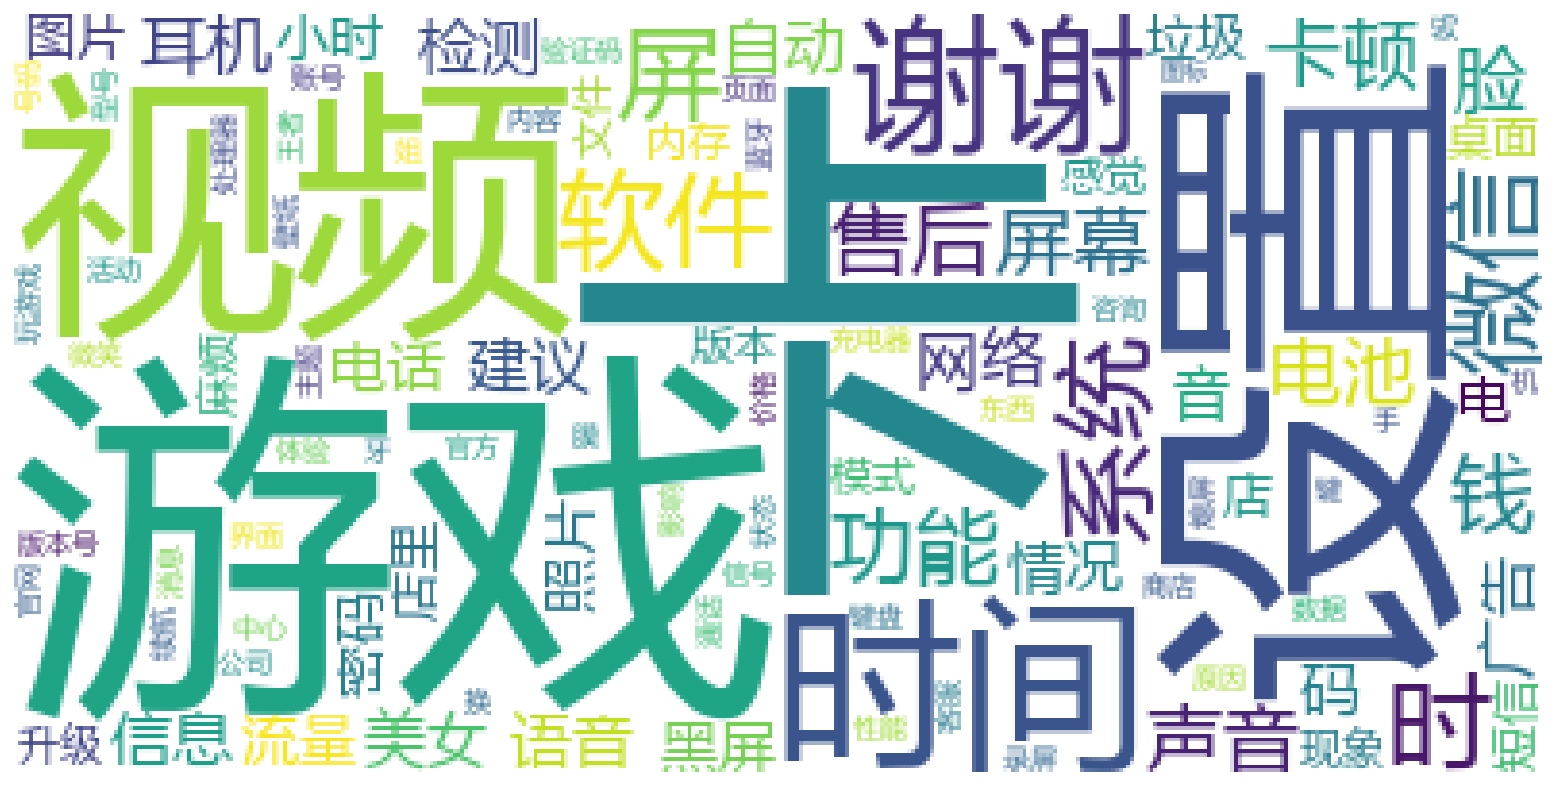

In [28]:
font=r"C:\Windows\Fonts\msyh.ttc"

wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white') #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(n_review_long_clean.word.values))
wordcloud.to_file('1_分词后的词云图(名词）.png')

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [29]:
#情感分析
#来自知网发布的情感分析用词语集

pos_comment=pd.read_csv('./正面评价词语（中文）.csv',header=None,encoding='utf-8') 
neg_comment=pd.read_csv('./负面评价词语（中文）.csv',header=None,encoding='utf-8')

pos_emotion=pd.read_csv('./正面情感词语（中文）.csv',header=None,encoding='utf-8')
neg_emotion=pd.read_csv('./负面情感词语（中文）.csv',header=None,encoding='utf-8')

In [30]:
pos_comment.shape
neg_comment.shape

pos_emotion.shape
neg_emotion.shape

(3743, 1)

(3138, 1)

(833, 1)

(1251, 1)

In [31]:
#合并情感/评价表
pos=pd.concat([pos_comment,pos_emotion],axis=0)
pos.shape
pos.head()
neg=pd.concat([neg_comment,neg_emotion],axis=0)
neg.shape
pos.head()

(4576, 1)

,0
0,侻
1,俶傥
2,僄
3,劼
4,嫕


(4389, 1)

,0
0,侻
1,俶傥
2,僄
3,劼
4,嫕


In [32]:
#根据案例特点增加新词
#判断新词是否在原表中
c='点赞'
c in pos.values

d='歇菜'
d in neg.values

False

False

In [33]:
#添加新词到表中
new_pos=pd.Series(['点赞'])
new_neg=pd.Series(['歇菜'])
positive=pd.concat([pos,new_pos],axis=0)
positive.shape

negative=pd.concat([neg,new_neg],axis=0)
negative.shape

(4577, 1)

(4390, 1)

In [34]:
positive.columns=['review']
positive['weight']=pd.Series([1]*len(positive))
positive.head()

,review,weight
0,侻,1
1,俶傥,1
2,僄,1
3,劼,1
4,嫕,1


In [35]:
negative.columns=['review']
negative['weight']=pd.Series([-1]*len(negative))
negative.head()

,review,weight
0,僄,-1
1,啰啰唆唆,-1
2,啰啰嗦嗦,-1
3,啰里啰唆,-1
4,啰里啰嗦,-1


In [36]:
pos_neg=pd.concat([positive,negative],axis=0)
pos_neg.shape
pos_neg.head()

(8967, 2)

,review,weight
0,侻,1
1,俶傥,1
2,僄,1
3,劼,1
4,嫕,1


In [37]:
data=review_long_clean.copy()
review_mltype=pd.merge(data,pos_neg,how='left',left_on='word',right_on='review')
review_mltype.shape

review_mltype=review_mltype.drop(['review'],axis=1)
review_mltype=review_mltype.replace(np.nan,0)
review_mltype.head()

(552229, 7)

,index_content,word,nature,content_type,index_word,weight
0,1,天猫,n,发热赛道,1,0.0
1,1,官方,n,发热赛道,2,0.0
2,1,旗舰店,v,发热赛道,3,0.0
3,1,购机,n,发热赛道,4,0.0
4,1,反馈,v,发热赛道,5,0.0


In [38]:
notdict=pd.read_csv('./not.csv')
notdict.shape

notdict['freq']=[1]*len(notdict)
notdict.head()

(21, 1)

,term,freq
0,不,1
1,没,1
2,无,1
3,非,1
4,莫,1


In [39]:
review_mltype['amend_weight']=review_mltype['weight']
review_mltype['id']=np.arange(0,review_mltype.shape[0])
review_mltype.head()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,1,天猫,n,发热赛道,1,0.0,0.0,0
1,1,官方,n,发热赛道,2,0.0,0.0,1
2,1,旗舰店,v,发热赛道,3,0.0,0.0,2
3,1,购机,n,发热赛道,4,0.0,0.0,3
4,1,反馈,v,发热赛道,5,0.0,0.0,4


In [40]:
# 只保留有情感值的行

only_review_mltype=review_mltype[review_mltype['weight']!=0]
only_review_mltype.index=np.arange(0,only_review_mltype.shape[0]) #索引重置
only_review_mltype.shape
only_review_mltype.head()

(7533, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
0,4,慢,a,性能赛道,1,-1.0,-1.0,97
1,5,不好,d,内置程序,21,-1.0,-1.0,149
2,5,不好,d,内置程序,53,-1.0,-1.0,181
3,7,垃圾,n,内置程序,19,-1.0,-1.0,230
4,13,慢,a,性能赛道,5,-1.0,-1.0,347


In [41]:
i=4
review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]]
review_i#第i个情感词的评论

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
343,13,微信,vn,性能赛道,1,0.0,0.0,343
344,13,扫码,n,性能赛道,2,0.0,0.0,344
345,13,打开,v,性能赛道,3,0.0,0.0,345
346,13,相机,d,性能赛道,4,0.0,0.0,346
347,13,慢,a,性能赛道,5,-1.0,-1.0,347
348,13,扫,v,性能赛道,6,0.0,0.0,348
349,13,码卡,n,性能赛道,7,0.0,0.0,349
350,13,不行,v,性能赛道,8,0.0,0.0,350
351,13,打开,v,性能赛道,9,0.0,0.0,351
352,13,屏幕,n,性能赛道,10,0.0,0.0,352


In [42]:
#看该情感词前2个词，来判罚否定的语气。如果在句首，则没有否词，如果在句子的第二次词，则看前1个词，来判断否定的语气。

index=only_review_mltype['id']

for i in range(0,only_review_mltype.shape[0]):
    
    review_i=review_mltype[review_mltype['index_content']==only_review_mltype['index_content'][i]] #第i个情感词的评论
    review_i.index=np.arange(0,review_i.shape[0])#重置索引后，索引值等价于index_word
    word_ind = only_review_mltype['index_word'][i] #第i个情感值在该条评论的位置
    
    #第一种，在句首。则不用判断
    #第二种，在评论的第2个为位置
    if word_ind==2:
        ne=sum( [ review_i['word'][word_ind-1] in notdict['term']  ] )
        if ne==1:
            review_mltype['amend_weight'][index[i]] = -( review_mltype['weight'][index[i]] )
    #第三种，在评论的第2个位置以后       
    elif word_ind > 2:
        ne=sum( [ word in notdict['term'] for word in review_i['word'][[word_ind-1,word_ind-2]]  ] ) # 注意用中括号[word_ind-1,word_ind-2]
        if ne==1:
            review_mltype['amend_weight'][index[i]]=- ( review_mltype['weight'][index[i]] )

In [43]:
review_mltype.shape
review_mltype[(review_mltype['weight']-review_mltype['amend_weight'])!=0] #说明两列值一样

(552229, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,id


In [44]:
review_mltype.tail()

,index_content,word,nature,content_type,index_word,weight,amend_weight,id
552224,52455,数据,n,第三方程序,25,0.0,0.0,552224
552225,52455,抓取,v,第三方程序,26,0.0,0.0,552225
552226,52455,情况,n,第三方程序,27,0.0,0.0,552226
552227,52455,描述,v,第三方程序,28,0.0,0.0,552227
552228,52455,软件名称,n,第三方程序,29,0.0,0.0,552228


In [45]:
emotion_value=review_mltype.groupby('index_content',as_index=False)['amend_weight'].sum()
emotion_value.head()
emotion_value.to_csv('./1_emotion_value',index=True,header=True)

,index_content,amend_weight
0,1,0.0
1,2,0.0
2,3,0.0
3,4,-1.0
4,5,-2.0


In [46]:
#每条评论的amend_weight总和不等于零

content_emotion_value=emotion_value.copy()
content_emotion_value.shape
content_emotion_value=content_emotion_value[content_emotion_value['amend_weight']!=0]
content_emotion_value['ml_type']=''
content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'

content_emotion_value.shape
content_emotion_value.head()

(49931, 2)

C:\Users\FOREST\AppData\Local\Temp\ipykernel_4624\2363425304.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight']>0]='pos'
C:\Users\FOREST\AppData\Local\Temp\ipykernel_4624\2363425304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_emotion_value['ml_type'][content_emotion_value['amend_weight']<0]='neg'


(5489, 3)

,index_content,amend_weight,ml_type
3,4,-1.0,neg
4,5,-2.0,neg
6,7,-1.0,neg
12,13,-1.0,neg
35,36,3.0,pos


In [47]:
#每条评论的amend_weight总和等于零

content_emotion_value0=emotion_value.copy()
content_emotion_value0=content_emotion_value0[content_emotion_value0['amend_weight']==0]
content_emotion_value0.head()


,index_content,amend_weight
0,1,0.0
1,2,0.0
2,3,0.0
5,6,0.0
7,8,0.0


In [48]:
#合并到大表中
content_emotion_value.columns
content_emotion_value=content_emotion_value.drop(['amend_weight'],axis=1)
review_mltype.shape
review_mltype=pd.merge(review_mltype,content_emotion_value,how='left',left_on='index_content',right_on='index_content')
review_mltype.columns
review_mltype=review_mltype.drop(['id'],axis=1)
review_mltype.shape
review_mltype.head()

review_mltype.to_csv('./1_review_mltype',index=True,header=True)

Index(['index_content', 'amend_weight', 'ml_type'], dtype='object')

(552229, 8)

Index(['index_content', 'word', 'nature', 'content_type', 'index_word',
       'weight', 'amend_weight', 'id', 'ml_type'],
      dtype='object')

(552229, 8)

,index_content,word,nature,content_type,index_word,weight,amend_weight,ml_type
0,1,天猫,n,发热赛道,1,0.0,0.0,NaN
1,1,官方,n,发热赛道,2,0.0,0.0,NaN
2,1,旗舰店,v,发热赛道,3,0.0,0.0,NaN
3,1,购机,n,发热赛道,4,0.0,0.0,NaN
4,1,反馈,v,发热赛道,5,0.0,0.0,NaN


In [68]:
cate=['index_content','content_type','ml_type']
data_type=review_mltype[cate].drop_duplicates()

confusion_matrix=pd.crosstab(data_type['content_type'],data_type['ml_type'],margins=True)
confusion_matrix['neg/All'] = confusion_matrix.apply(lambda x: x['neg']/x['All'], axis=1)
confusion_matrix.sort_values('neg/All', ascending=False, inplace=True)
confusion_matrix = confusion_matrix[confusion_matrix['All'] > 100]
confusion_matrix

ml_type,neg,pos,All,neg/All
content_type,,,,
系统流畅性,173,32,205,0.843902
第三方程序,261,76,337,0.774481
性能赛道,1312,401,1713,0.765908
All,3817,1672,5489,0.695391
发热赛道,118,53,171,0.690058
外观设计,212,113,325,0.652308
续航赛道,203,132,335,0.605970
内置程序,810,553,1363,0.594277


In [50]:
data=review_mltype.copy()
data=data[data['amend_weight']!=0]

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

<Figure size 1500x700 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

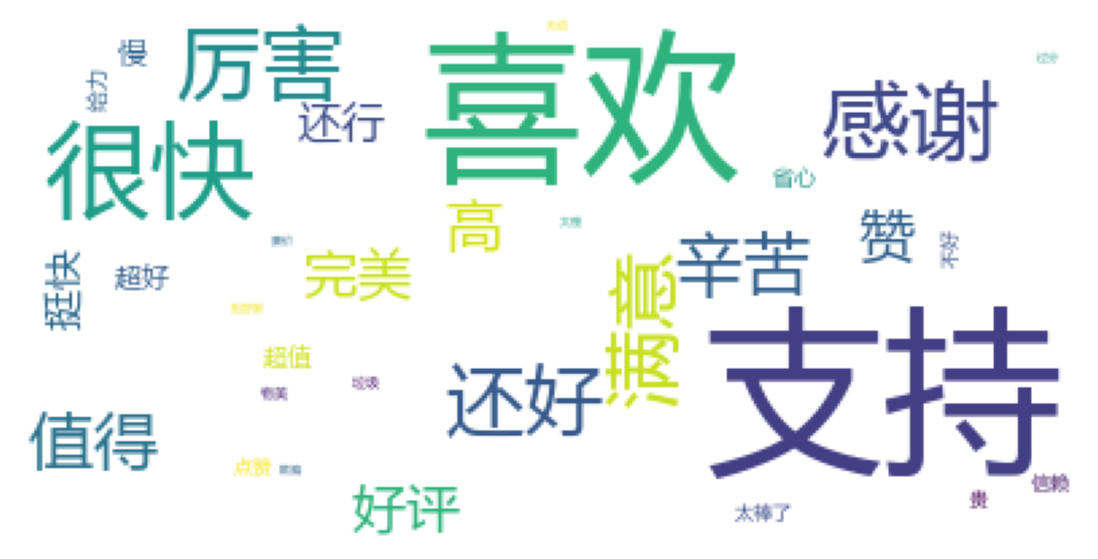

In [51]:
font=r"C:\Windows\Fonts\msyh.ttc"


wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white') #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1500x700 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

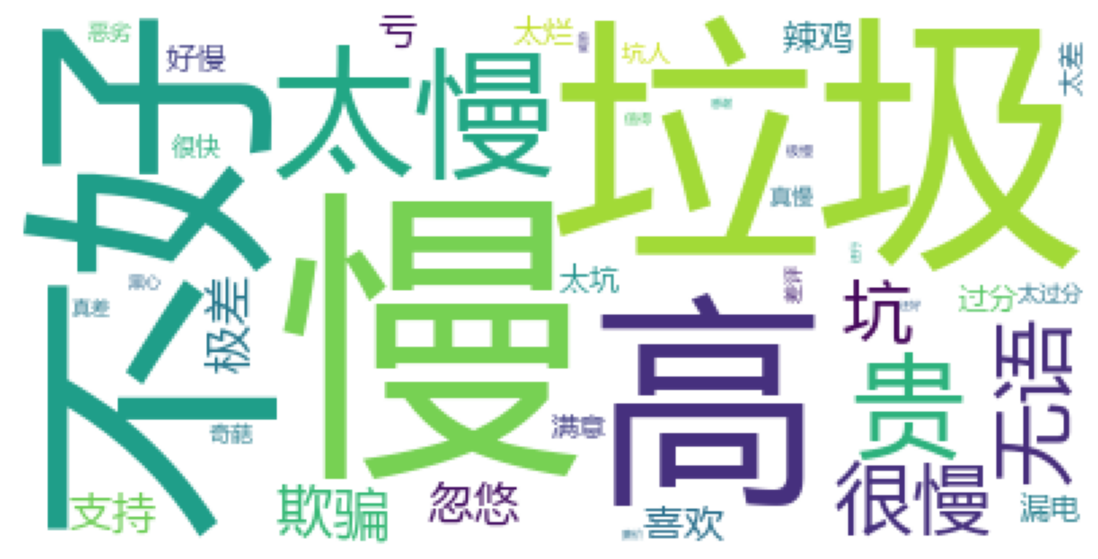

In [52]:
font=r"C:\Windows\Fonts\msyh.ttc"


wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white') #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1500x700 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

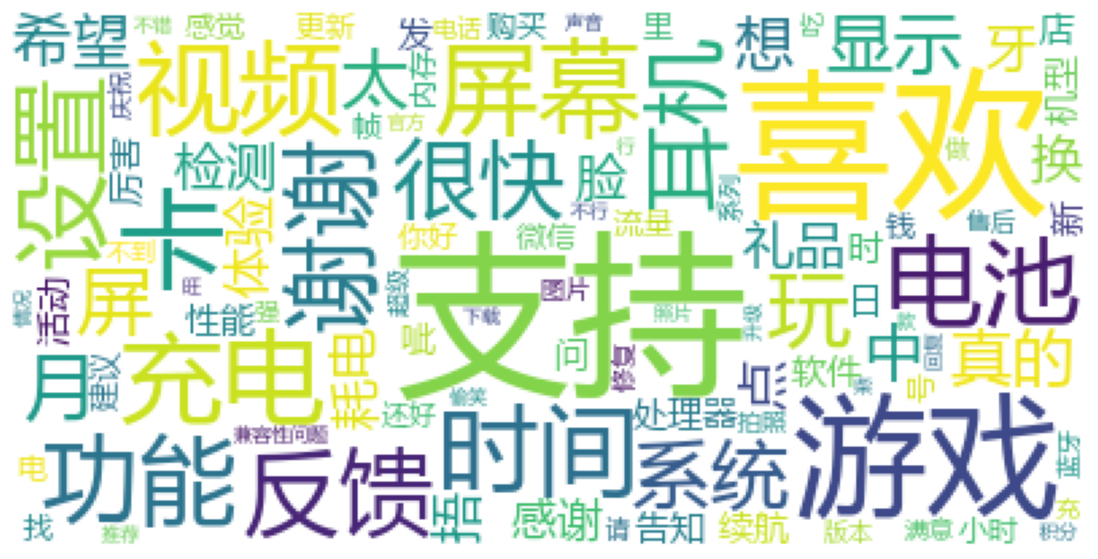

<Figure size 1500x700 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

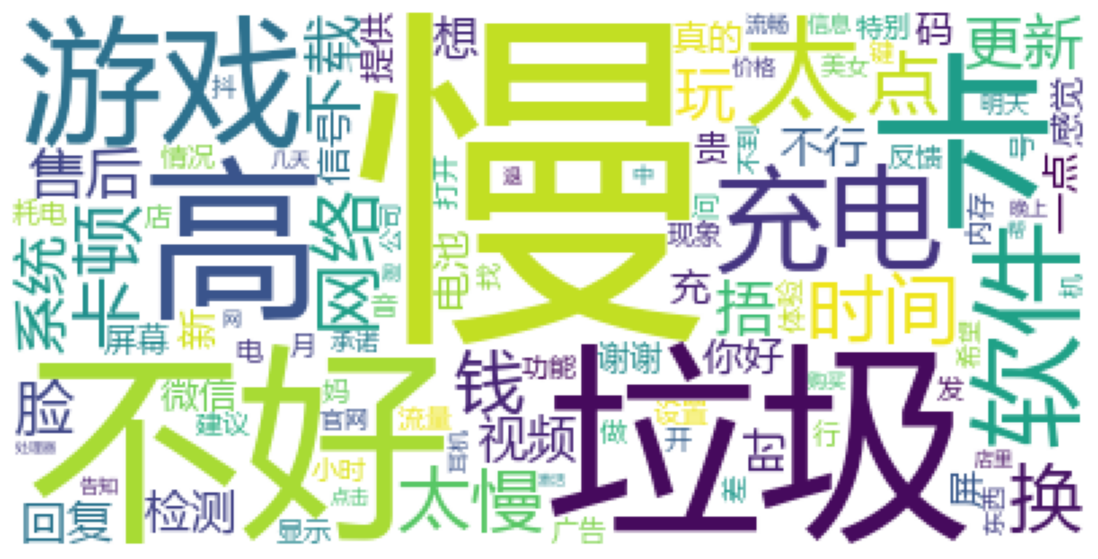

In [53]:
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

font=r"C:\Windows\Fonts\msyh.ttc"


wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white') #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_pos.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


wordcloud = WordCloud(font_path=font, max_words = 100, mode='RGBA' ,background_color='white') #width=1600,height=1200
wordcloud.generate_from_frequencies(Counter(word_data_neg.word.values))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [54]:
#LDA
data=review_mltype.copy()

word_data_pos=data[data['ml_type']=='pos']
word_data_neg=data[data['ml_type']=='neg']

In [55]:
#建立词典，去重

pos_dict=corpora.Dictionary([ [i] for i in word_data_pos.word]) #shape=(n,1)
neg_dict=corpora.Dictionary([ [i] for i in word_data_neg.word])

In [56]:
print(pos_dict)

Dictionary(9894 unique tokens: ['贵', '微信', '信息', '闪', '灯光']...)


In [57]:
#建立语料库

pos_corpus=[ pos_dict.doc2bow(j) for j in [ [i] for i in word_data_pos.word] ] 
neg_corpus=[ neg_dict.doc2bow(j) for j in [ [i] for i in word_data_neg.word] ]

In [58]:
len(word_data_pos.word)
len(pos_dict)
len(pos_corpus)
pos_corpus  

53387

9894

53387

[[(0, 1)],
 [(1, 1)],
 [(2, 1)],
 [(3, 1)],
 [(4, 1)],
 [(5, 1)],
 [(6, 1)],
 [(7, 1)],
 [(8, 1)],
 [(9, 1)],
 [(10, 1)],
 [(3, 1)],
 [(4, 1)],
 [(2, 1)],
 [(5, 1)],
 [(11, 1)],
 [(2, 1)],
 [(9, 1)],
 [(12, 1)],
 [(3, 1)],
 [(4, 1)],
 [(5, 1)],
 [(13, 1)],
 [(14, 1)],
 [(15, 1)],
 [(16, 1)],
 [(17, 1)],
 [(9, 1)],
 [(3, 1)],
 [(4, 1)],
 [(9, 1)],
 [(13, 1)],
 [(18, 1)],
 [(19, 1)],
 [(14, 1)],
 [(20, 1)],
 [(21, 1)],
 [(14, 1)],
 [(22, 1)],
 [(15, 1)],
 [(1, 1)],
 [(3, 1)],
 [(4, 1)],
 [(9, 1)],
 [(13, 1)],
 [(23, 1)],
 [(21, 1)],
 [(24, 1)],
 [(25, 1)],
 [(26, 1)],
 [(6, 1)],
 [(27, 1)],
 [(28, 1)],
 [(26, 1)],
 [(25, 1)],
 [(29, 1)],
 [(30, 1)],
 [(26, 1)],
 [(6, 1)],
 [(31, 1)],
 [(32, 1)],
 [(15, 1)],
 [(33, 1)],
 [(34, 1)],
 [(35, 1)],
 [(36, 1)],
 [(7, 1)],
 [(37, 1)],
 [(38, 1)],
 [(33, 1)],
 [(34, 1)],
 [(35, 1)],
 [(39, 1)],
 [(40, 1)],
 [(41, 1)],
 [(42, 1)],
 [(43, 1)],
 [(44, 1)],
 [(45, 1)],
 [(46, 1)],
 [(34, 1)],
 [(47, 1)],
 [(9, 1)],
 [(48, 1)],
 [(25, 1)],
 [(25, 1)],

In [59]:
#构造主题数寻优函数

def cos(vector1,vector2):
    dot_product=0.0
    normA=0.0
    normB=0.0
    for a,b in zip(vector1,vector2):
        dot_product +=a*b
        normA +=a**2
        normB +=b**2
    if normA==0.0 or normB==0.0:
        return None
    else:
        return ( dot_product/((normA*normB)**0.5) )

In [60]:
#主题数寻优

def LDA_k(x_corpus,x_dict):
    #初始化平均余玄相似度
    mean_similarity=[]
    mean_similarity.append(1)
    
    #循环生成主题并计算主题间相似度
    for i in np.arange(2,11):
        lda=models.LdaModel(x_corpus,num_topics=i,id2word=x_dict) #LDA模型训练
        
        for j in np.arange(i):
            term=lda.show_topics(num_words=50)
        
        #提取各主题词
        top_word=[] #shape=(i,50)
        for k in np.arange(i):
            top_word.append( [''.join(re.findall('"(.*)"',i)) for i in term[k][1].split('+')]) #列出所有词
        
        #构造词频向量
        word=sum(top_word,[]) #列车所有词
        unique_word=set(word) #去重
        
        #构造主题词列表，行表示主题号，列表示各主题词
        mat=[] #shape=(i,len(unique_word))
        for j in np.arange(i):
            top_w=top_word[j]
            mat.append( tuple([ top_w.count(k) for k in unique_word ])) #统计list中元素的频次，返回元组
        
        #两两组合。方法一
        p=list(itertools.permutations(list(np.arange(i)),2)) #返回可迭代对象的所有数学全排列方式。
        y=len(p) # y=i*(i-1)
        top_similarity=[0]
        for w in np.arange(y):
            vector1=mat[p[w][0]]
            vector2=mat[p[w][1]]
            top_similarity.append(cos(vector1,vector2))

            
        #计算平均余玄相似度
        mean_similarity.append(sum(top_similarity)/ y)
    return mean_similarity

In [61]:
#计算主题平均余玄相似度

pos_k=LDA_k(pos_corpus,pos_dict)
neg_k=LDA_k(neg_corpus,neg_dict)

pos_k
neg_k

[1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

<AxesSubplot:>

Text(0.5, 1.0, '正面评论LDA主题数寻优')

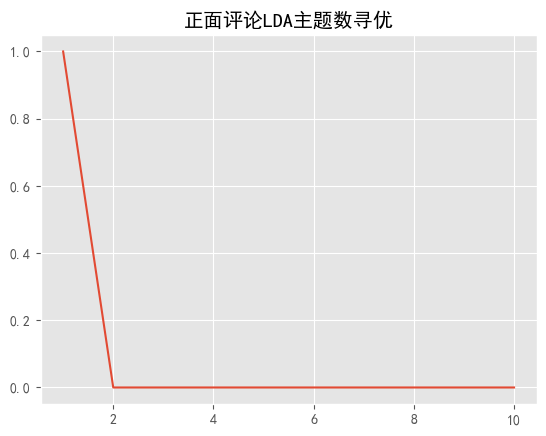

In [62]:
pd.Series(pos_k,index=range(1,11)).plot()
plt.title('正面评论LDA主题数寻优')
plt.show()

<AxesSubplot:>

Text(0.5, 1.0, '负面评论LDA主题数寻优')

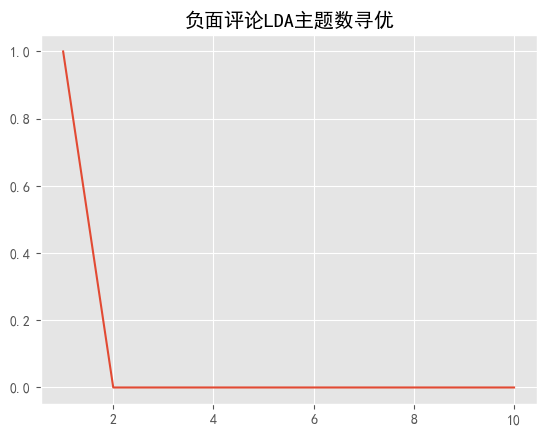

In [63]:
pd.Series(neg_k,index=range(1,11)).plot()
plt.title('负面评论LDA主题数寻优')
plt.show()

In [64]:
pos_lda=models.LdaModel(pos_corpus,num_topics=2,id2word=pos_dict)
neg_lda=models.LdaModel(neg_corpus,num_topics=2,id2word=neg_dict)

pos_lda.print_topics(num_topics=10)
neg_lda.print_topics(num_topics=10)

[(0,
  '0.014*"耳机" + 0.011*"喜欢" + 0.011*"充电" + 0.011*"处理器" + 0.008*"设置" + 0.008*"反馈" + 0.007*"游戏" + 0.007*"时间" + 0.007*"电池" + 0.007*"功能"'),
 (1,
  '0.029*"支持" + 0.010*"屏幕" + 0.008*"蓝牙" + 0.007*"流量" + 0.007*"卡" + 0.006*"系统" + 0.005*"礼品" + 0.005*"系列" + 0.005*"连接" + 0.005*"出厂"')]

[(0,
  '0.017*"慢" + 0.015*"高" + 0.014*"卡" + 0.010*"捂" + 0.010*"充电" + 0.010*"时间" + 0.009*"太" + 0.009*"换" + 0.008*"售后" + 0.006*"激活"'),
 (1,
  '0.025*"垃圾" + 0.024*"不好" + 0.016*"游戏" + 0.010*"脸" + 0.009*"钱" + 0.007*"玩" + 0.007*"信号" + 0.007*"网络" + 0.006*"官网" + 0.006*"想"')]